The purpose of this notebook is two-fold: 
1. It contains the code required to reproduce (most of) the figures in the paper "*Beyond BAO: improving cosmological constraints from BOSS with measurement of the void-galaxy cross-correlation*", **S. Nadathur** *et al.*, 2019 ([arXiv:1904.01030](https://arxiv.org/abs/1904.01030)); and 
2. it provides a short demonstration of how to use the ```VoidGalaxyPosterior``` class to plot model predictions and compare them with data measurements, estimate cosmological quantities, etc. It operates using the data provided in the ```BOSS_DR12_CMASS_data/``` folder.

**Requirements:**
     - Python 3.7 or higher
     - numpy
     - scipy
     - getdist (for plotting posteriors from MCMC analysis)
     
We start by importing required modules and setting plotting preferences:

In [1]:
import numpy as np
import importlib.util
from getdist import plots, MCSamples
from scipy.integrate import quad
from scipy.interpolate import InterpolatedUnivariateSpline
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import rc
rc('font',**{'family':'sans-serif'})
rc('text', usetex=True)
rc('axes', linewidth=1.3)
rc('font', **{'weight':'bold'})

from posterior_samplers.void_galaxy_posterior import VoidGalaxyPosterior
from utilities.utilities import FigureUtilities, Cosmology, UtilMethods
from utilities.multipoles import correlation_multipoles
fu = FigureUtilities()

We load the parameters relevant to the BOSS DR12 data from file, and use these to initialise an instance of ```VoidGalaxyPosterior```:

In [2]:
spec = importlib.util.spec_from_file_location("name", 'parameters/boss_cmass_params.py')
params = importlib.util.module_from_spec(spec)
spec.loader.exec_module(params)
vgpost = VoidGalaxyPosterior(params)

### Comparison of different theory models (modification of Figure 2 of [arXiv:1904.01030](https://arxiv.org/abs/1904.01030))

Although the parameters file we imported specified the theory model to use for likelihood analyses to be Model 1 (i.e., the model used in [arXiv:1904.01030](https://arxiv.org/abs/1904.01030)), it is still possible to obtain the predictions for Model 2 (the quasi-linear model of Cai *et al.* [arXiv:1603.05184](https://arxiv.org/abs/1603.05184)) for comparison. With a little bit of extra work, we can also get the prediction (for the quadrupole only) for Model 3 (the multipole ratio model of Cai *et al.*). We plot all three of these predictions for the quadrupole at a fiducial point in parameter space for comparison.

Notes: 
 -  "Model 3" is a Kaiser model that only includes terms up to $\mathcal{O}(\delta)$ but not terms of similar magnitude proportional to $\xi\delta$ (i.e., it is mathematically inconsistent)
 -  "Model 1 without dispersion" is a Kaiser model that correctly includes all linear order terms including those of $\mathcal{O}(\xi\delta)$, but not does not account for dispersion around the coherent outflow velocity
 -  "Model 2" is simply a Gaussian streaming model for the galaxy autocorrelation, incorrectly extended to the void-galaxy case by analogy
 -  "Model 1" is the full model that includes terms of $\mathcal{O}(\xi\delta)$ as well as velocity dispersion

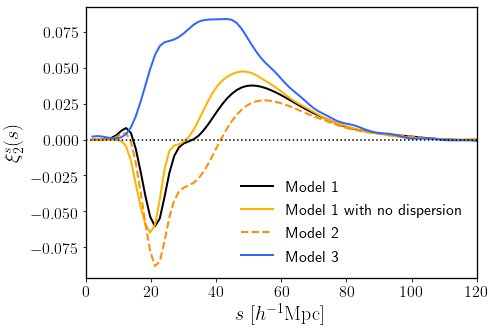

In [3]:
fs8, bs8, sv, aperp, apar = 0.5, 1.14, 380, 1, 1
s = np.linspace(2, 120., 81)
colors = fu.RdYlBu[[1, 3, 5, 6, 8]]

model1 = vgpost.model1_theory_full(fs8, bs8, sv, aperp, apar, s)
model1_no_disp = vgpost.model1_theory_full(fs8, bs8, 20, aperp, apar, s)
model2 = vgpost.model2_theory_full(fs8, bs8, sv, aperp, apar, s)

data = vgpost.interpolated_data_vector(beta=fs8 / bs8)
xi_s_mono = InterpolatedUnivariateSpline(vgpost.data_rvals, data[:len(vgpost.data_rvals)])
integral = np.zeros_like(vgpost.data_rvals)
for i in range(len(integral)):
    integral[i] = quad(lambda x: xi_s_mono(x) * x**2, 0, vgpost.data_rvals[i], full_output=1)[0]
int_xi_s_mono = InterpolatedUnivariateSpline(vgpost.data_rvals, 3*integral/vgpost.data_rvals**3, ext=3)
model3 = vgpost.model3_theory_quadrupole(fs8 / bs8, xi_s_mono(s), int_xi_s_mono(s))

plt.figure(figsize=(7, 5))
plt.plot(s, model1[len(s):], lw=2, c='k', label=r'Model 1')
plt.plot(s, model1_no_disp[len(s):], lw=2, c=colors[2], label=r'Model 1 with no dispersion')
plt.plot(s, model2[len(s):], lw=2, c=colors[3], label=r'Model 2', ls='--')
plt.plot(s, model3, lw=2, c=colors[0], label='Model 3')

plt.tick_params(labelsize=16)
plt.xlim([0, 120])
plt.axhline(0, c='k', ls=':')
plt.xlabel(r'$s\;[h^{-1}\mathrm{Mpc}]$', fontsize=20)
plt.ylabel(r'$\xi^s_2(s)$', fontsize=20)
plt.legend(loc='lower right', numpoints=1, frameon=False, fontsize=16);

### Theory model dependence on parameters (Figure 3 of [arXiv:1904.01030](https://arxiv.org/abs/1904.01030))

We start by plotting the theory model for the void-galaxy quadrupole moment $\xi_2^s(s)$ and visualising its dependence on the Alcock-Paczynski parameter ratio $\epsilon=\frac{\alpha_\perp}{\alpha_{||}}$ (proportional to $F_\mathrm{AP}$) and the growth rate $f\sigma_8$. Similar plots could be obtained for the monopole, but would be less informative as the curves are harder to distinguish by eye.

Note that the call to ```model1_theory_full()``` specifies $\alpha_\perp$ and $\alpha_{||}$ individually, although the model depends only on the ratio $\alpha_\perp/\alpha_{||}$.

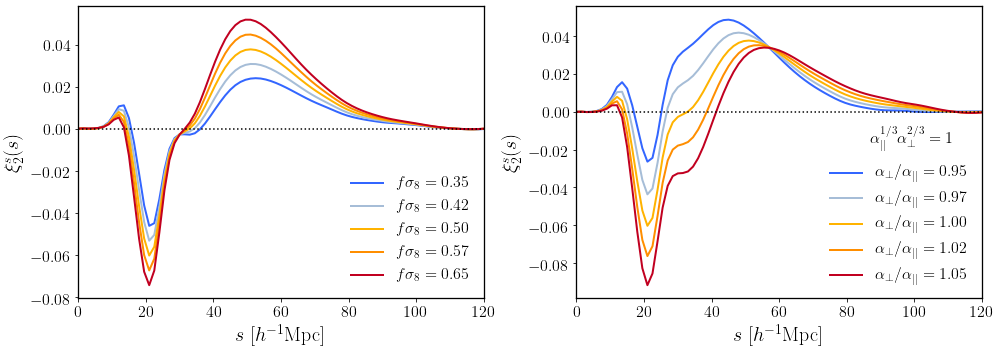

In [4]:
# the values to vary
fs8_vals = np.linspace(0.35, 0.65, 5)
eps_vals = np.linspace(0.95, 1.05, 5)

# define some fiducial values of parameters
fsigma8 = 0.5
bsigma8 = 1.14
sigmav = 380
aperp, apar = 1, 1

s = np.linspace(0.01, 120., 81)
colors = fu.RdYlBu[[1, 3, 5, 6, 8]]

plt.figure(figsize=(14,5))
plt.subplot(1, 2, 1)
for i, fs8 in enumerate(fs8_vals):    
    quadrupole = vgpost.model1_theory_full(fs8, bsigma8, sigmav, aperp, apar, s)[len(s):]
    plt.plot(s, quadrupole, lw=2, c=colors[i], label=r'$f\sigma_8=%0.2f$' % fs8)
plt.tick_params(labelsize=16)
plt.xlim([0, 120])
plt.axhline(0, c='k', ls=':')
plt.xlabel(r'$s\;[h^{-1}\mathrm{Mpc}]$', fontsize=20)
plt.ylabel(r'$\xi^s_2(s)$', fontsize=20)
plt.legend(loc='lower right', numpoints=1, frameon=False, fontsize=16);

plt.subplot(1, 2, 2)
for i, eps in enumerate(eps_vals):    
    quadrupole = vgpost.model1_theory_full(fsigma8, bsigma8, sigmav, eps**(1/3), eps**(-2/3), s)[len(s):]
    plt.plot(s, quadrupole, lw=2, c=colors[i], label=r'$\alpha_\perp/\alpha_{||}=%0.2f$' % eps)
plt.tick_params(labelsize=16)
plt.text(87, -0.019, r'$\alpha_{||}^{1/3}\alpha_\perp^{2/3}=1$', fontsize=16);
plt.xlim([0, 120])
plt.axhline(0, c='k', ls=':')
plt.xlabel(r'$s\;[h^{-1}\mathrm{Mpc}]$', fontsize=20)
plt.ylabel(r'$\xi^s_2(s)$', fontsize=20)
plt.legend(loc='lower right', numpoints=1, frameon=False, fontsize=16);
plt.tight_layout(w_pad=1)

### Calibrated $\delta(r)$ and normalised velocity dispersion profiles (Figure 4 of [arXiv:1904.01030](https://arxiv.org/abs/1904.01030))

Now we plot the matter density profile $\delta(r)$ (equivalent to the void-matter cross-correlation monopole) and the normalised velocity dispersion profile $\sigma_{v_{||}}(r)/\sigma_v$ calibrated from mocks in the BigMultiDark simulation, that are used for generating the theory model:

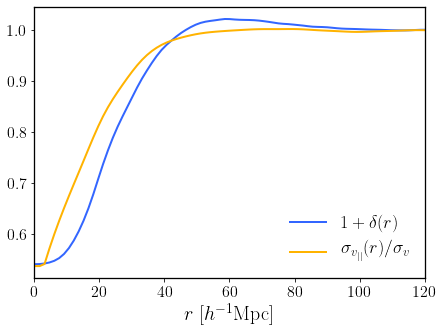

In [5]:
plt.figure(figsize=(7,5))
s = np.linspace(0.2, 120., 81)
plt.plot(s, 1 + vgpost.delta_r(s), c=fu.RdYlBu[1], lw=2, label=r'$1+\delta(r)$')
plt.plot(s, vgpost.sv_norm_func(s), c=fu.RdYlBu[5], lw=2, label=r'$\sigma_{v_{||}}(r)/\sigma_v$')
plt.tick_params(labelsize=16)
plt.xlim([0, 120])
plt.xlabel(r'$r\;[h^{-1}\mathrm{Mpc}]$', fontsize=20)
plt.legend(loc='lower right', numpoints=1, frameon=False, fontsize=18);


### The correlation matrix, at specified $\beta$ (Figure 6 of [arXiv:1904.01030](https://arxiv.org/abs/1904.01030))

To visualise the structure of the covariance matrix we can plot the correlation matrix. As the covariance matrix in principle depends on the value of $\beta = f/b$ used in the reconstruction, we plot this at a single value of $\beta$ corresponding to the fiducial growth rate $f=0.77$ and bias $b=1.85$.

Note that this covariance matrix was obtained from measuring the void-galaxy multipoles on 1000 MD-Patchy mocks.

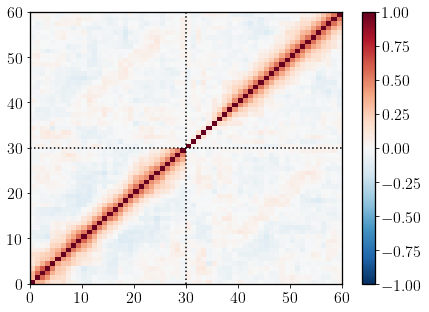

In [6]:
beta = 0.77 / 1.85
corr_mat = vgpost.interpolated_corrmat(beta)
plt.figure(figsize=(7, 5))
plt.pcolormesh(corr_mat, cmap=plt.cm.RdBu_r, vmax=1, vmin=-1)
cb = plt.colorbar()
plt.tick_params(labelsize=16)
cb.ax.tick_params(labelsize=16)
plt.axhline(30, c='k', ls=':')
plt.axvline(30, c='k', ls=':')

### Maximum likelihood theory compared to the measured data (Figure 7 of [arXiv:1904.01030](https://arxiv.org/abs/1904.01030))

The maximum likelihood point in parameter space was estimated using the ```basinghopping``` package in ```scipy```: we won't calculate this again, but simply load the point that was previously saved to file. Note that in this figure we multiply the $1\sigma$ errorbars on the monopole by 2 in order to aid visibility, but there is no need to do so for the quadrupole.

Chi-squared at ML point = 59.30, for (60-4) degrees of freedom


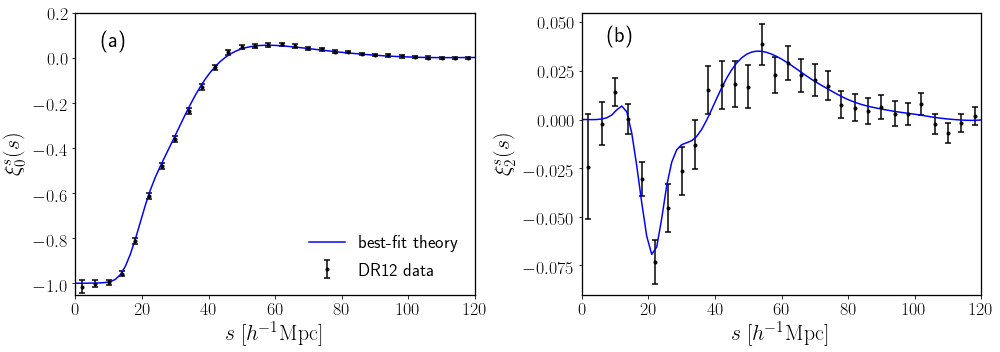

In [7]:
ml_point = np.loadtxt('BOSS_DR12_CMASS_data/maxLikelihood/cmass_maxlike_point.txt')
fs8, bs8, sv, aperp, apar = ml_point[1], ml_point[2], ml_point[3], ml_point[5]**(1/3), ml_point[5]**(-2/3)

s = np.linspace(0.01, 120., 81)
theory = vgpost.model1_theory_full(fs8, bs8, sv, aperp, apar, s)
data = vgpost.interpolated_data_vector(beta=fs8 / bs8)
covmat = vgpost.interpolated_covmat(beta=fs8 / bs8)
errors = np.sqrt(np.diag(covmat))

plt.figure(figsize=(14,5))
plt.subplot(1, 2, 1)
plt.errorbar(vgpost.data_rvals, data[:len(vgpost.data_rvals)], yerr=2 * errors[:len(vgpost.data_rvals)], 
             c='k', fmt='.', elinewidth=1.5, capsize=3, capthick=1.5, label='DR12 data')    
plt.plot(s, theory[:len(s)], lw=1.5, label='best-fit theory', c='blue')
plt.legend(loc='lower right', numpoints=1, frameon=False, fontsize=18)
plt.tick_params(labelsize=18)
plt.xlabel(r"$s\;[h^{-1}\mathrm{Mpc}]$", fontsize=22)
plt.ylabel(r"$\xi^s_0(s)$", fontsize=22)
plt.text(7.6, 0.05, '(a)', weight='bold', style='italic', fontsize=22)
plt.ylim([-1.05, 0.2])
plt.xlim([0, 120])

plt.subplot(1, 2, 2)
plt.errorbar(vgpost.data_rvals, data[len(vgpost.data_rvals):], yerr=errors[len(vgpost.data_rvals):], 
             c='k', fmt='.', elinewidth=1.5, capsize=3, capthick=1.5, label='DR12 data')    
plt.plot(s, theory[len(s):], lw=1.5, label='best-fit theory', c='blue')
plt.tick_params(labelsize=18)
plt.xlabel(r"$s\;[h^{-1}\mathrm{Mpc}]$", fontsize=22)
plt.ylabel(r"$\xi^s_2(s)$", fontsize=22)
plt.text(7.6, 0.04, '(b)', fontweight='bold', style='italic', fontsize=22)
plt.ylim([-0.09, 0.055])
plt.xlim([0, 120])

plt.tight_layout(w_pad=1)

theta = [fs8, bs8, sv, ml_point[5]]
print("Chi-squared at ML point = %0.2f, for (60-4) degrees of freedom" % vgpost.chisq(theta))

### Triangle plot for marginalised posterior constraints (Figure 8 of [arXiv:1904.01030](https://arxiv.org/abs/1904.01030))

We simply load the previously produced ```emcee``` chain from file rather than re-running from scratch, and use ```getdist``` to plot the posteriors. The chain file has the following columns: multiplicity, log_posterior, $f\sigma_8$, $b\sigma_8$, $\sigma_v$, $\alpha$, $\epsilon$, $\alpha_\perp$, $\alpha_{||}$. (Note that the multiplicity is always 1 for ```emcee``` chains but was recorded anyway to match ```getdist``` expected format. Also note that the log posterior does not depend on $\alpha$, but it was included to demonstrate this point and enable other posterior plots.)

Removed no burn in
68% c.l.:
	f\sigma_8 = 0.501\pm 0.051
	b\sigma_8 = 1.37\pm 0.14
	\sigma_v\;[\mathrm{km}/\mathrm{s}] = 387^{+50}_{-40}
	\alpha = ---
	\alpha_\perp/\alpha_{||} = 1.016\pm 0.011
95% c.l.:
	f\sigma_8 = 0.501^{+0.10}_{-0.097}
	b\sigma_8 = 1.37^{+0.27}_{-0.26}
	\sigma_v\;[\mathrm{km}/\mathrm{s}] = 387^{+80}_{-90}
	\alpha = ---
	\alpha_\perp/\alpha_{||} = 1.016^{+0.021}_{-0.021}


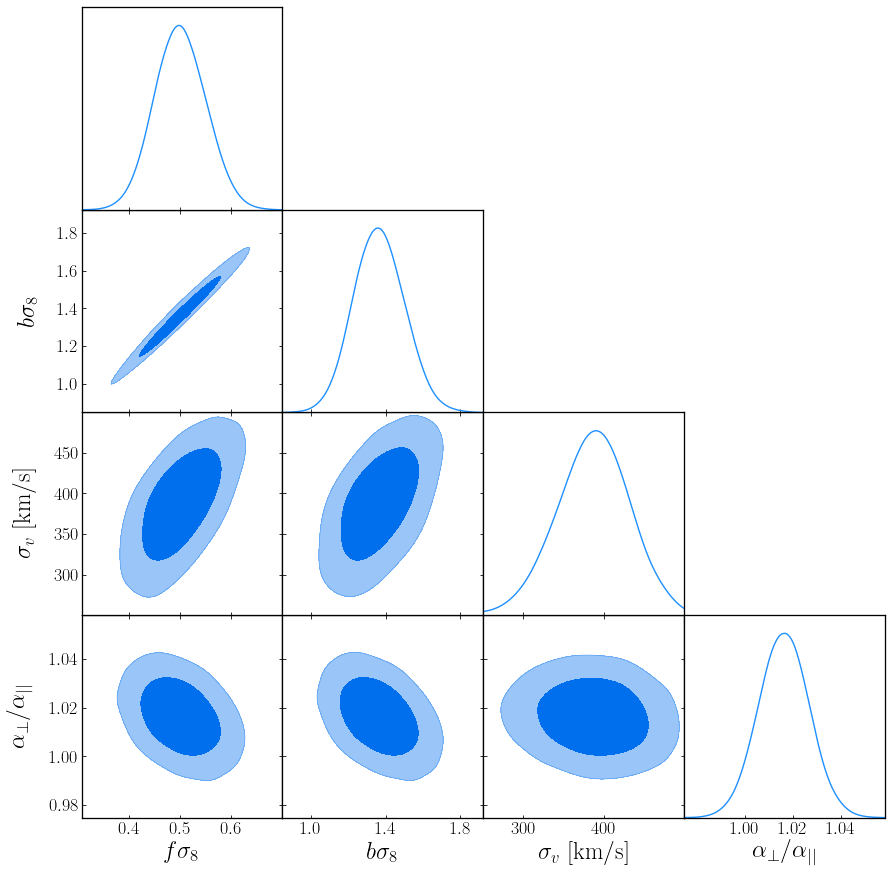

In [8]:
chain = np.load('BOSS_DR12_CMASS_data/emcee_chains/cmass_model1_full_chain.npy')
names = ["fs8", "bs8", "sv", "alpha", "epsilon"]
labels =  ["f\sigma_8", "b\sigma_8", "\sigma_v\;[\mathrm{km}/\mathrm{s}]", "\\alpha", 
           "\\alpha_\perp/\\alpha_{||}"]
void_samples = MCSamples(samples=chain[:, 1:], names=names, labels=labels, 
                         ranges={'sv':(250, 500), 'alpha':(0.8, 1.2)}, 
                         settings={'fine_bins_2D': 256, 'smooth_scale_1D': 0.3, 'smooth_scale_2D': 0.4})
p = void_samples.getParams() 
void_samples.addDerived((p.fs8 / p.bs8), name='beta', label='\\beta')
void_samples.addDerived(p.alpha * p.epsilon**(-2./3) , name='apar', label='\\alpha_{||}', range=[0.81, 1.19])
void_samples.addDerived(p.alpha * p.epsilon**(1./3) , name='aperp', label='\\alpha_\perp', range=[0.81, 1.19])

g = plots.getSubplotPlotter(width_inch=12)
g.triangle_plot(void_samples, params=['fs8', 'bs8', 'sv', 'epsilon'], contour_lws=[1.4], filled=True, 
                line_args={'lw':2, 'color':'dodgerblue'}, tight_layout=True)

for i in range(4):
    for ax in g.subplots[i:,i]:
        ax.tick_params(labelsize=18)
        ax.set_ylabel(ax.get_ylabel(), fontsize=24, labelpad=15)
        ax.set_xlabel(ax.get_xlabel(), fontsize=24, labelpad=25)

print('68% c.l.:')
for name in names:
    print('\t' + void_samples.getInlineLatex(name,limit=1))
print('95% c.l.:')
for name in names:
    print('\t' + void_samples.getInlineLatex(name,limit=2))


### Test for systematics using the Patchy mocks (Figures 9 and 10 of [arXiv:1904.01030](https://arxiv.org/abs/1904.01030))

Scatter plot of the values of $f\sigma_8$ and $\alpha_\perp/\alpha_{||}$ obtained from ML analysis on each of the 1000 MD-Patchy mocks.

Text(0, 0.5, '$f\\sigma_8$')

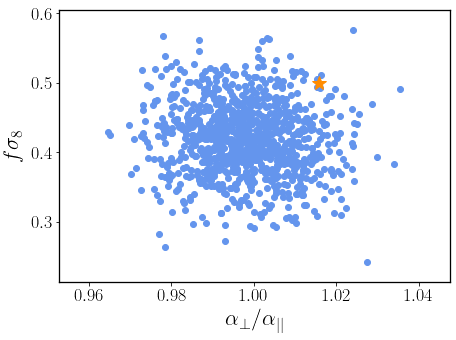

In [9]:
patchy_ml_points = np.load('BOSS_DR12_CMASS_data/maxLikelihood/patchy-mocks_maxlike_points.npy')
ml_point = np.loadtxt('BOSS_DR12_CMASS_data/maxLikelihood/cmass_maxlike_point.txt')

plt.figure(figsize=(7,5))
plt.scatter(patchy_ml_points[:, 5], patchy_ml_points[:, 1], c='cornflowerblue')
plt.plot(ml_point[5], ml_point[1], '*', c='darkorange', markersize=14, markeredgecolor='darkorange')
plt.tick_params(labelsize=18)
plt.xlabel(r"$\alpha_\perp/\alpha_{||}$", fontsize=22)
plt.ylabel(r"$f\sigma_8$", fontsize=22)

Comparison of the quadrupole moment for DR12 data relative to the mean and $1\sigma$ range of the quadrupoles in the Patchy mocks. Note that the Patchy mocks have a somewhat different bias to the CMASS galaxies ($b_\mathrm{Patchy}=2.10$ vs. $b_\mathrm{CMASS}=1.85$ for the fiducial values used in the BOSS DR12 papers), so we plot these quadrupoles at the same value of $f$ (taken to be the fiducial value $f=0.78$ for the Planck $\Lambda$CDM cosmology at $z=0.57$) rather than at the same $\beta$.

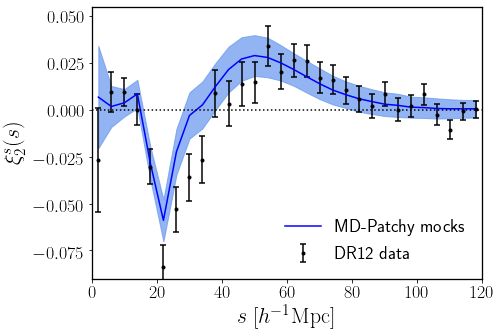

In [10]:
f = 0.78

from scipy.interpolate import InterpolatedUnivariateSpline

data = vgpost.interpolated_data_vector(beta=f / 1.85)
covmat = vgpost.interpolated_covmat(beta=f / 1.85)
errors = np.sqrt(np.diag(covmat))
plt.figure(figsize=(7, 5))
plt.errorbar(vgpost.data_rvals, data[len(vgpost.data_rvals):], yerr=errors[len(vgpost.data_rvals):], 
             c='k', fmt='.', elinewidth=1.5, capsize=3, capthick=1.5, label='DR12 data')    

patchy_multipoles = np.load('BOSS_DR12_CMASS_data/patchy_combined_recon_zobov-Voids_xi_s_multipoles_R0.50.npy',
                            allow_pickle=True).item()
patchy = np.zeros(patchy_multipoles['multipoles'].shape[1])
for i in range(len(patchy)):
    interpolater = InterpolatedUnivariateSpline(vgpost.beta_grid, patchy_multipoles['multipoles'][:, i], k=3, ext=2)
    patchy[i] = interpolater(f / 2.10)
covmat = vgpost.interpolated_covmat(beta=f / 2.10)
errors = np.sqrt(np.diag(covmat))
plt.plot(vgpost.data_rvals, patchy[len(vgpost.data_rvals):], c='b', label='MD-Patchy mocks')
plt.fill_between(vgpost.data_rvals, patchy[len(vgpost.data_rvals):] - errors[len(vgpost.data_rvals):],
                 patchy[len(vgpost.data_rvals):] + errors[len(vgpost.data_rvals):], 
                 color='cornflowerblue', alpha=0.7)

plt.tick_params(labelsize=18)
plt.xlabel(r"$s\;[h^{-1}\mathrm{Mpc}]$", fontsize=22)
plt.ylabel(r"$\xi^s_2(s)$", fontsize=22)
plt.legend(loc='lower right', numpoints=1, frameon=False, fontsize=18)
plt.ylim([-0.09, 0.055])
plt.xlim([0, 120])
plt.axhline(0, c='k', ls=':')


**Note**: the code to reproduce the remaining figures in [arXiv:1904.01030](https://arxiv.org/abs/1904.01030) is not strictly related to the use of this package so is not included here, but is available on request!